In [56]:
%load_ext autoreload
%autoreload 2

import os
import sys

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")
sys.path.append(ROOT_DIR)  # To find local version of the library
sys.path.append(os.path.abspath("../")) 

import pandas as pd

IMAGE_DIR = os.path.join(ROOT_DIR, "BCCD_Dataset/BCCD")
IMAGE_DIR2 = os.path.join(ROOT_DIR, "segmentation_WBC")
REPO_DIR = os.path.join(ROOT_DIR, "maskrcnn-master")

import pandas as pd
import os
import json
from utils.utils import *
import colorsys
import random
import numpy as np
import cv2
import xml.etree.ElementTree as ET
import imageio
from matplotlib import patches
from matplotlib.patches import Polygon
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Dataset A from https://www.kaggle.com/paultimothymooney/blood-cells
## Sample ids and split Train/Val 

In [24]:
def parse_WBC_types(text):
    try:
        types = []
        for i in text.split(','):
            types.append(i.strip())
        return types
    except Exception as e:
        #print(f"EX {e}")
        return []

In [25]:
label_df = pd.read_csv('../../dataset-master/labels.csv')
label_df = label_df.drop(["Unnamed: 0"], axis=1)
label_df["index"] = label_df["Image"].apply(lambda x: f"{x:05d}")
label_df["WBC_types"] = label_df["Category"].apply(parse_WBC_types)

In [9]:
from os import walk
sample_df_dict = []
for (dirpath, dirnames, filenames) in walk(os.path.join(IMAGE_DIR, "JPEGImages")):
    for filename in filenames:
        sample_df_dict.append({"index": filename[:-4].split('_')[-1],
                               "sample_id": filename[:-4]})
    break
sample_df = pd.DataFrame(sample_df_dict)

In [29]:
dataset_A_df = sample_df.merge(label_df, how="left", on="index")

In [41]:
val_sample_ids = []
val_sample_ids += list(dataset_A_df[dataset_A_df.Category == "NEUTROPHIL"].sample(frac=0.2).sample_id.values)
val_sample_ids += list(dataset_A_df[dataset_A_df.Category == "EOSINOPHIL"].sample(frac=0.2).sample_id.values)
val_sample_ids += list(dataset_A_df[dataset_A_df.Category == "LYMPHOCYTE"].sample(frac=0.2).sample_id.values)
val_sample_ids += list(dataset_A_df[dataset_A_df.Category == "MONOCYTE"].sample(frac=0.2).sample_id.values)

In [44]:
dataset_A_df["role"] = dataset_A_df["sample_id"].apply(lambda x: "val" if x in val_sample_ids else "train")
dataset_A_df["origin"] = "A"

In [45]:
print(f"Samples in total {len(dataset_A_df)}")
print(f'Samples in train {len(dataset_A_df[dataset_A_df["role"] == "train"])}, \
      Samples in val {len(dataset_A_df[dataset_A_df["role"] == "val"])}')

Samples in total 364
Samples in train 295,       Samples in val 69


## Visualize a random sample in dataset A (kaggle)

(480, 640, 3) (480, 640, 10)


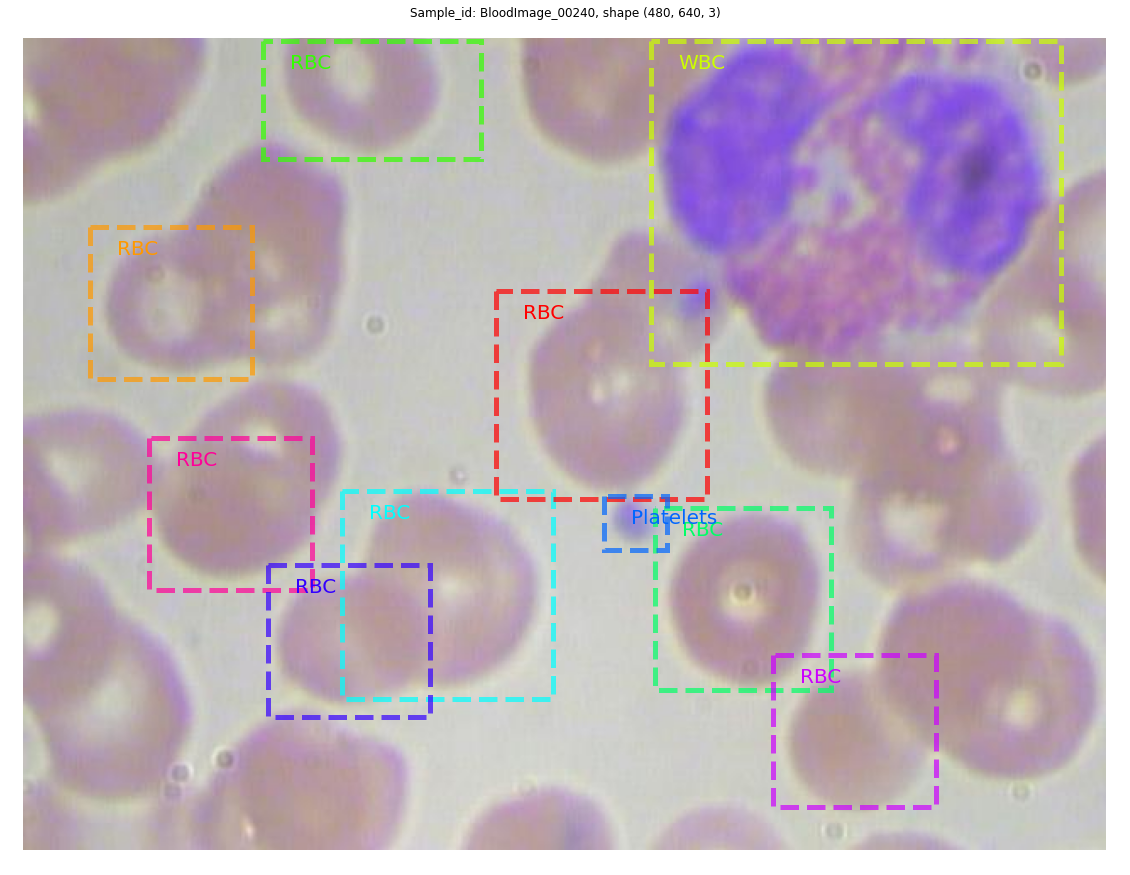

In [46]:
visualize_sample(dataset_A_df.sample(1).sample_id.iloc[0], IMAGE_DIR)

In [47]:
dataset_A_df

,index,sample_id,Image,Category,WBC_types,role,origin
0,00177,BloodImage_00177,177,EOSINOPHIL,[EOSINOPHIL],train,A
1,00258,BloodImage_00258,258,LYMPHOCYTE,[LYMPHOCYTE],val,A
2,00214,BloodImage_00214,214,NEUTROPHIL,[NEUTROPHIL],train,A
3,00066,BloodImage_00066,66,NEUTROPHIL,[NEUTROPHIL],train,A
4,00242,BloodImage_00242,242,"NEUTROPHIL,EOSINOPHIL","[NEUTROPHIL, EOSINOPHIL]",train,A
...,...,...,...,...,...,...,...
359,00058,BloodImage_00058,58,EOSINOPHIL,[EOSINOPHIL],val,A
360,00108,BloodImage_00108,108,EOSINOPHIL,[EOSINOPHIL],train,A
361,00124,BloodImage_00124,124,NEUTROPHIL,[NEUTROPHIL],train,A
362,00137,BloodImage_00137,137,EOSINOPHIL,[EOSINOPHIL],train,A


# Dataset B from https://github.com/zxaoyou/segmentation_WBC

In [82]:
def get_WBC_type(i):
    if i == 1:
        return "neutrophil".upper()
    elif i == 2:
        return "lymphocyte".upper()
    elif i == 3:
        return "monocyte".upper()
    elif i == 4:
        return "eosinophil".upper()
    elif i == 5:
        return "basophil".upper()
    else:
        return None
# The labels (1- 5) represent neutrophil, lymphocyte, monocyte, eosinophil and basophil
dataset_B_df = pd.read_csv(os.path.join(IMAGE_DIR2, "Class Labels of Dataset 2.csv"))
dataset_B_df["sample_id"] = dataset_B_df["image ID"].apply(lambda x: f"{x:03d}")
dataset_B_df["Category"] = dataset_B_df["class"].apply(get_WBC_type)
dataset_B_df["WBC_types"] = dataset_B_df["Category"].apply(lambda x: [x])
dataset_B_df["role"] = "train"
dataset_B_df["origin"] = "B"

In [83]:
from utils.utils import *
def visualize_sample_B(df: pd.DataFrame, sample_id: str, IMAGE_DIR: str) -> None:
    WBC_types = df[df["sample_id"] == sample_id].WBC_types.iloc[0]
    print(sample_id, WBC_types)
    image = read_image(get_image_local_path_B(sample_id, IMAGE_DIR))
    mask = read_image(get_mask_local_path_B(sample_id, IMAGE_DIR))
    masks = mask[..., 0:1]
    class_names = WBC_types
    _, ax = plt.subplots(1, figsize=(20, 20))
    colors = random_colors(len(class_names))
    height, width = image.shape[:2]
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')
    ax.set_title(f"Sample_id: {sample_id}, shape {image.shape}, WBC type {WBC_types}")
    print(image.shape, masks.shape)
    masked_image = image.astype(np.uint32).copy()
    
    for i, class_name in enumerate(class_names):
        mask = masks[..., i]
        ret, thresh = cv2.threshold(mask.astype(np.uint8), 1, 255, 0)
        cnt, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        cnt = np.squeeze(cnt[0], axis=1)
        p = Polygon(cnt,
                    facecolor="none", edgecolor=colors[i], alpha=0.7, linestyle="dashed", 
                    linewidth=5, fill=False)
        ax.add_patch(p)

        # Label
        ax.text(cnt[0,0] + 16, cnt[0,1] + 16, class_name,
                color=colors[i], size=20, backgroundcolor="none")

    ax.imshow(masked_image.astype(np.uint8))
    plt.show()

091 ['LYMPHOCYTE']
(300, 300, 3) (300, 300, 1)


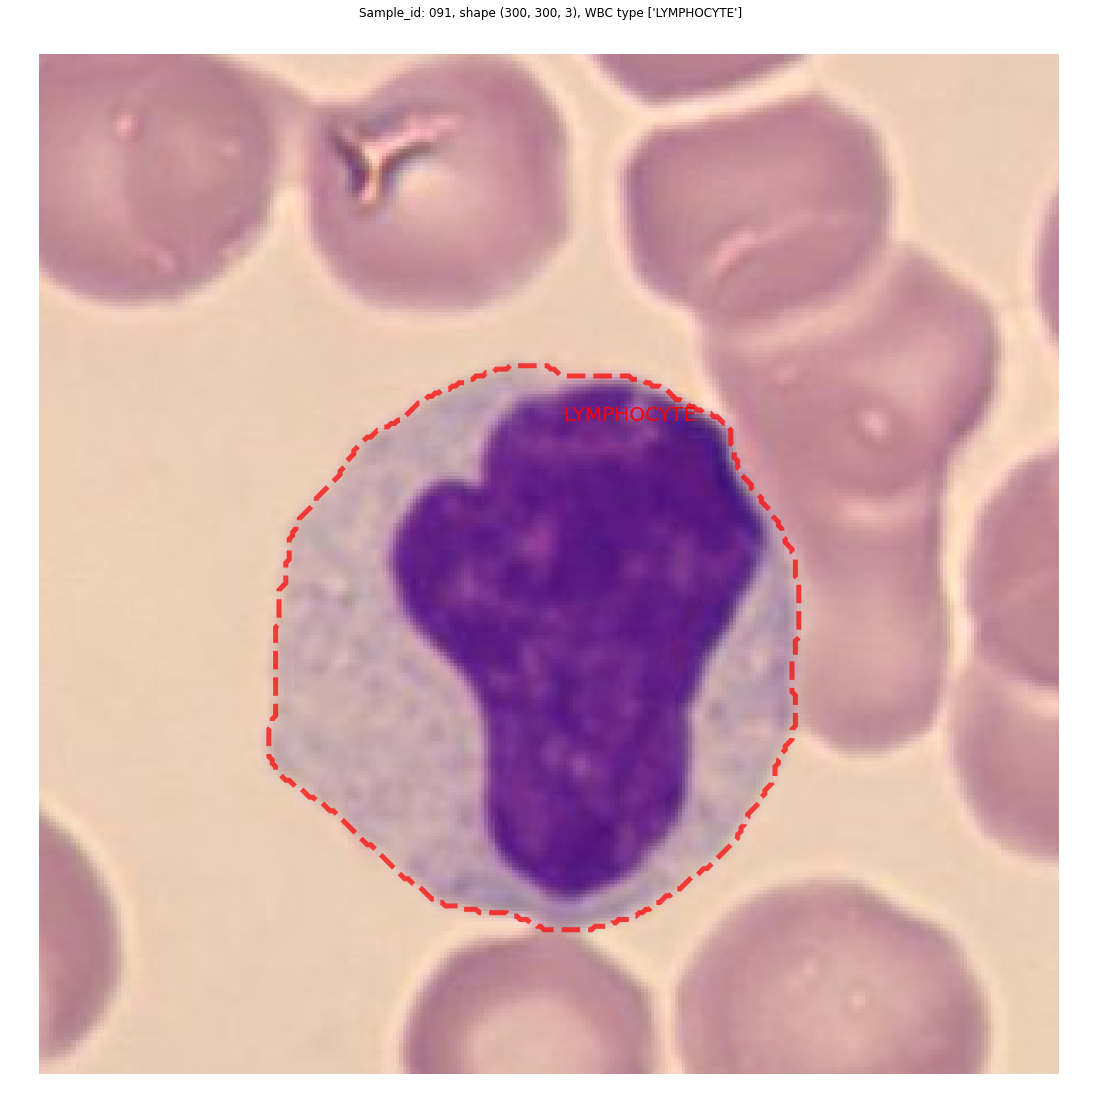

In [84]:
visualize_sample_B(dataset_B_df, dataset_B_df.sample(1).sample_id.iloc[0], IMAGE_DIR2)

In [87]:
dataset_all = pd.concat([dataset_A_df[["sample_id", "WBC_types", "role", "origin"]], dataset_B_df[["sample_id", "WBC_types", "role", "origin"]]], ignore_index=True)

In [89]:
dataset_all.to_pickle(r'../blood_cell_dataset.pkl')